In [50]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [51]:
import numpy as np
import pandas as pd

In [52]:
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [53]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [54]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [55]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [56]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [57]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [58]:
# Get a list of column names and types
mcolumns = inspector.get_columns('measurement')
for c in mcolumns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [59]:
# Get a list of column names and types
scolumns = inspector.get_columns('station')
for c in scolumns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [60]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [61]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [62]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the last date
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(latest_date)

('2017-08-23',)


In [63]:
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)

2016-08-23


In [64]:
# Perform a query to retrieve the data and precipitation scores
last_12mo_prcp= session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= '2016-08-23').filter(Measurement.date <= '2017-08-23').order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
df_last12mo_prcp = pd.DataFrame(last_12mo_prcp)
df_last12mo_prcp.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


In [65]:
#drop NaN values
df_last12mo_prcp=df_last12mo_prcp.dropna()
#set index as date
df_last12mo_prcp.set_index('date').head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


In [66]:
df_last12mo_prcp.max()

date    2017-08-23
prcp           6.7
dtype: object

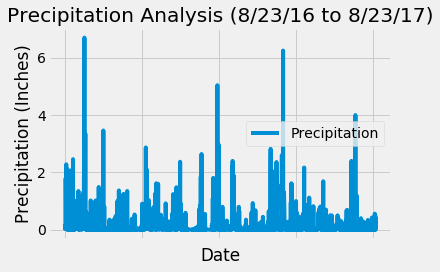

In [67]:
# Use Pandas Plotting with Matplotlib to plot the data
# Define months for x-ticks labels

df_last12mo_prcp.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Precipitation (Inches)")
plt.title("Precipitation Analysis (8/23/16 to 8/23/17)")
plt.legend(["Precipitation"])
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.savefig("2017precipitation.png")
plt.show("2017precipitation.png")

In [68]:
plt.gcf().clear()

<Figure size 432x288 with 0 Axes>

In [69]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_last12mo_prcp.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [70]:
# How many stations are available in this dataset?
total_stations = session.query(func.count(Station.station))
total_stations[0]

(9)

In [71]:
# What are the most active stations?
# List the stations and the counts in descending order.
top_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
top_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [72]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.station=='USC00519281')
most_active_station[0]

(54.0, 85.0, 71.66378066378067)

In [73]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_station_12motobs = session.query(Measurement.date, Measurement.tobs)\
    .filter(Measurement.station == 'USC00519281')\
    .filter(Measurement.date >= last_year)\
    .order_by(Measurement.date).all()

df_activestation_tobs= pd.DataFrame(active_station_12motobs)
df_activestation_tobs.head()
# Plot the bar graph from the histogram data

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


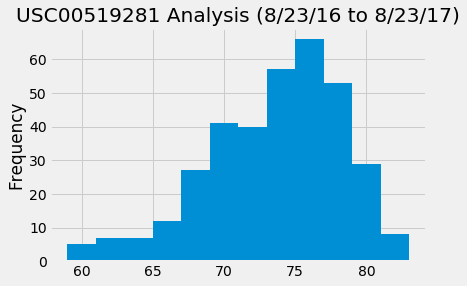

In [74]:
plt.hist(df_activestation_tobs['tobs'],12)
plt.ylabel("Frequency")
plt.title("USC00519281 Analysis (8/23/16 to 8/23/17)")
plt.savefig("station_histogram.png")
plt.show()

### TEMP ANALYSIS OPTIONAL

In [262]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [263]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [264]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [265]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [266]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [267]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [268]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [269]:
# Plot the daily normals as an area plot with `stacked=False`
